# Feature engineer summary

## 1. Vote results for all features


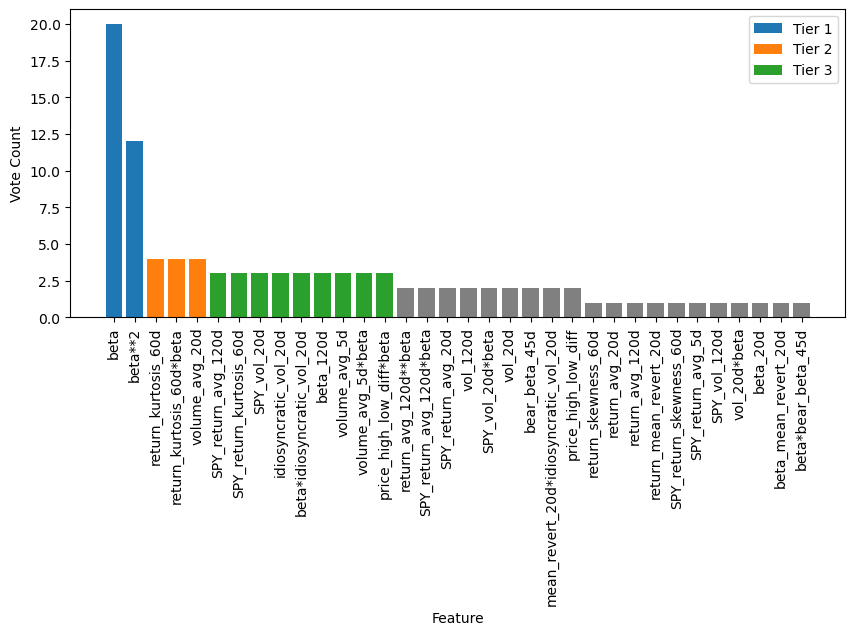

In [1]:
import os, sys, copy, scipy, datetime, tqdm, collections, itertools, pickle
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import subprocess

if __name__ == "__main__":
    sys.path.append(os.path.join(os.getcwd(), '..'))
import utils

file_name = os.path.join(os.getcwd(), "../data/data_transformed.npz")
data = np.load(file_name, allow_pickle=True)
code_list = data["code_list"].tolist(); ticker_list = data["ticker_list"].tolist(); time_axis = data["time_axis"].tolist()
adjclose = data["adjclose"]; volume = data["volume"]; return_ = data["return_"]
beta = data["beta"]; forward_beta = data["forward_beta"]
SPY_adjclose = data["SPY_adjclose"]; SPY_volume = data["SPY_volume"]; SPY_return = data["SPY_return"]
N = len(code_list); T = len(time_axis)

file_name = os.path.join(os.getcwd(), "../data/feature_dict.pkl")
with open(file_name, "rb") as f:
    feature_dict = pickle.load(f)

'''
file_name = os.path.join(os.getcwd(), "feature_vote.pkl")
if os.path.exists(file_name):
    os.remove(file_name)

scripts = [
    'return_based_features.py',
    'SPY_return_based_features.py',
    'volatility_based_features.py',
    'market_correlation_features.py',
    'volume_price_features.py'
]

for script in scripts:
    print(f'Running {script}...')
    try:
        result = subprocess.run(['python', script], capture_output=True, text=True)
        plt.close('all')
    except:
        raise Exception(f"Error running {script}")
'''

file_name_list = ["feature_vote_return.pkl", 
                  "feature_vote_SPY_return.pkl", 
                  "feature_vote_volatility.pkl", 
                  "feature_vote_market_correlation.pkl", 
                  "feature_vote_volume_price.pkl"]
feature_vote_summary = collections.defaultdict(int)
for file_name in file_name_list:
    with open(os.path.join(os.getcwd(), file_name), "rb") as f:
        feature_vote = pickle.load(f)
        for key, value in feature_vote.items():
            feature_vote_summary[key] += value

feature_vote_summary = sorted(feature_vote_summary.items(), key=lambda x: x[1], reverse=True)
plt.figure(figsize=(10, 4))
plt.bar([feature_vote_summary[i][0] for i in range(len(feature_vote_summary))], [feature_vote_summary[i][1] for i in range(len(feature_vote_summary))], color='grey')
selected_feature = [feature_vote_summary[i][0] for i in range(len(feature_vote_summary)) if feature_vote_summary[i][1] >= 10]
plt.bar(selected_feature, [feature_vote_summary[i][1] for i in range(len(feature_vote_summary)) if feature_vote_summary[i][0] in selected_feature], label="Tier 1")
selected_feature = [feature_vote_summary[i][0] for i in range(len(feature_vote_summary)) if feature_vote_summary[i][1] < 10 and feature_vote_summary[i][1] >= 4]
plt.bar(selected_feature, [feature_vote_summary[i][1] for i in range(len(feature_vote_summary)) if feature_vote_summary[i][0] in selected_feature], label="Tier 2")
selected_feature = [feature_vote_summary[i][0] for i in range(len(feature_vote_summary)) if feature_vote_summary[i][1] < 4 and feature_vote_summary[i][1] >=3]
plt.bar(selected_feature, [feature_vote_summary[i][1] for i in range(len(feature_vote_summary)) if feature_vote_summary[i][0] in selected_feature], label="Tier 3")
plt.xlabel("Feature")
plt.ylabel("Vote Count")
plt.xticks(rotation=90)
plt.legend()
plt.savefig(os.path.join(os.getcwd(), "feature_vote_summary.png"), dpi=300, bbox_inches='tight')


### Conclusion:

Based on the vote results, we can categorize the features into three groups by importance:

(1) **High importance**
   - $\beta$: current beta, the most predictive features for forward beta (kind of obvious due to stability of beta)
   - $\beta^2$: current beta squared, non-linear corrections of beta

(2) **Medium importance**
   - $r^{kurt, 60d}_{i, t} = \frac{1}{60}\sum_{j=0}^{59} (r_{i, t-j} - \bar{r}_{i, t})^4$:
 return_kurtosis_60d: 60-day rolling kurtosis of return
   - $r^{kurt, 60d}_{i, t}*\beta$: the interaction of kurtosis and beta
   - $V^{avg, 20d}_{i, t}$: 20-day average volume

(3) **Low importance**
   - $r^{SPY, 60d}_{i, t} = \frac{1}{60}\sum_{j=0}^{59} (r_{SPY, t-j} - \bar{r}_{SPY, t})^2$: 60-day rolling variance of SPY returns
   - $ r^{SPY kurt, 60d}_{i, t} = \frac{1}{60}\sum_{j=0}^{59} (r_{SPY, t-j} - \bar{r}_{SPY, t})^4$: 60-day rolling kurtosis of SPY returns
   - $ \sigma^{SPY, 60d}_{i, t} = \frac{1}{60}\sum_{j=0}^{59} (r_{SPY, t-j} - \bar{r}_{SPY, t})^2$: 60-day rolling volatility of SPY returns
   - $\epsilon_{i, t} = r_{i, t} - \beta^{20d}_{i, t} r_{SPY, t} \implies \sigma^{\epsilon}_{i, t} = \sqrt{\frac{1}{20}\sum_{j=0}^{19} (\epsilon_{i, t-j} - \bar{\epsilon}_{i, t})^2}$: 20-day rolling idiosyncratic volatility of return, , where $\bar{\epsilon}_{i, t}$ is the mean of $\epsilon_{i, t}$ over the past 20 days.
   - $\sigma^{\epsilon}_{i, t}* \beta$: the interaction of idiosyncratic volatility and beta
   - $\beta^{120d}_{i, t} = \frac{1}{120}\sum_{j=0}^{119} \beta_{i, t-j}$: 120-day rolling beta
   - $V^{avg, 5d}_{i, t}$: 5-day average volume
   - $V^{avg, 5d}_{i, t}*\beta$: 5-day average volume
   - $ (P^{high, 120d}_{i, t} - P^{low, 120d}_{i, t})*\beta$: price 120 day high-low spread times beta

## 2. Remove colinear features

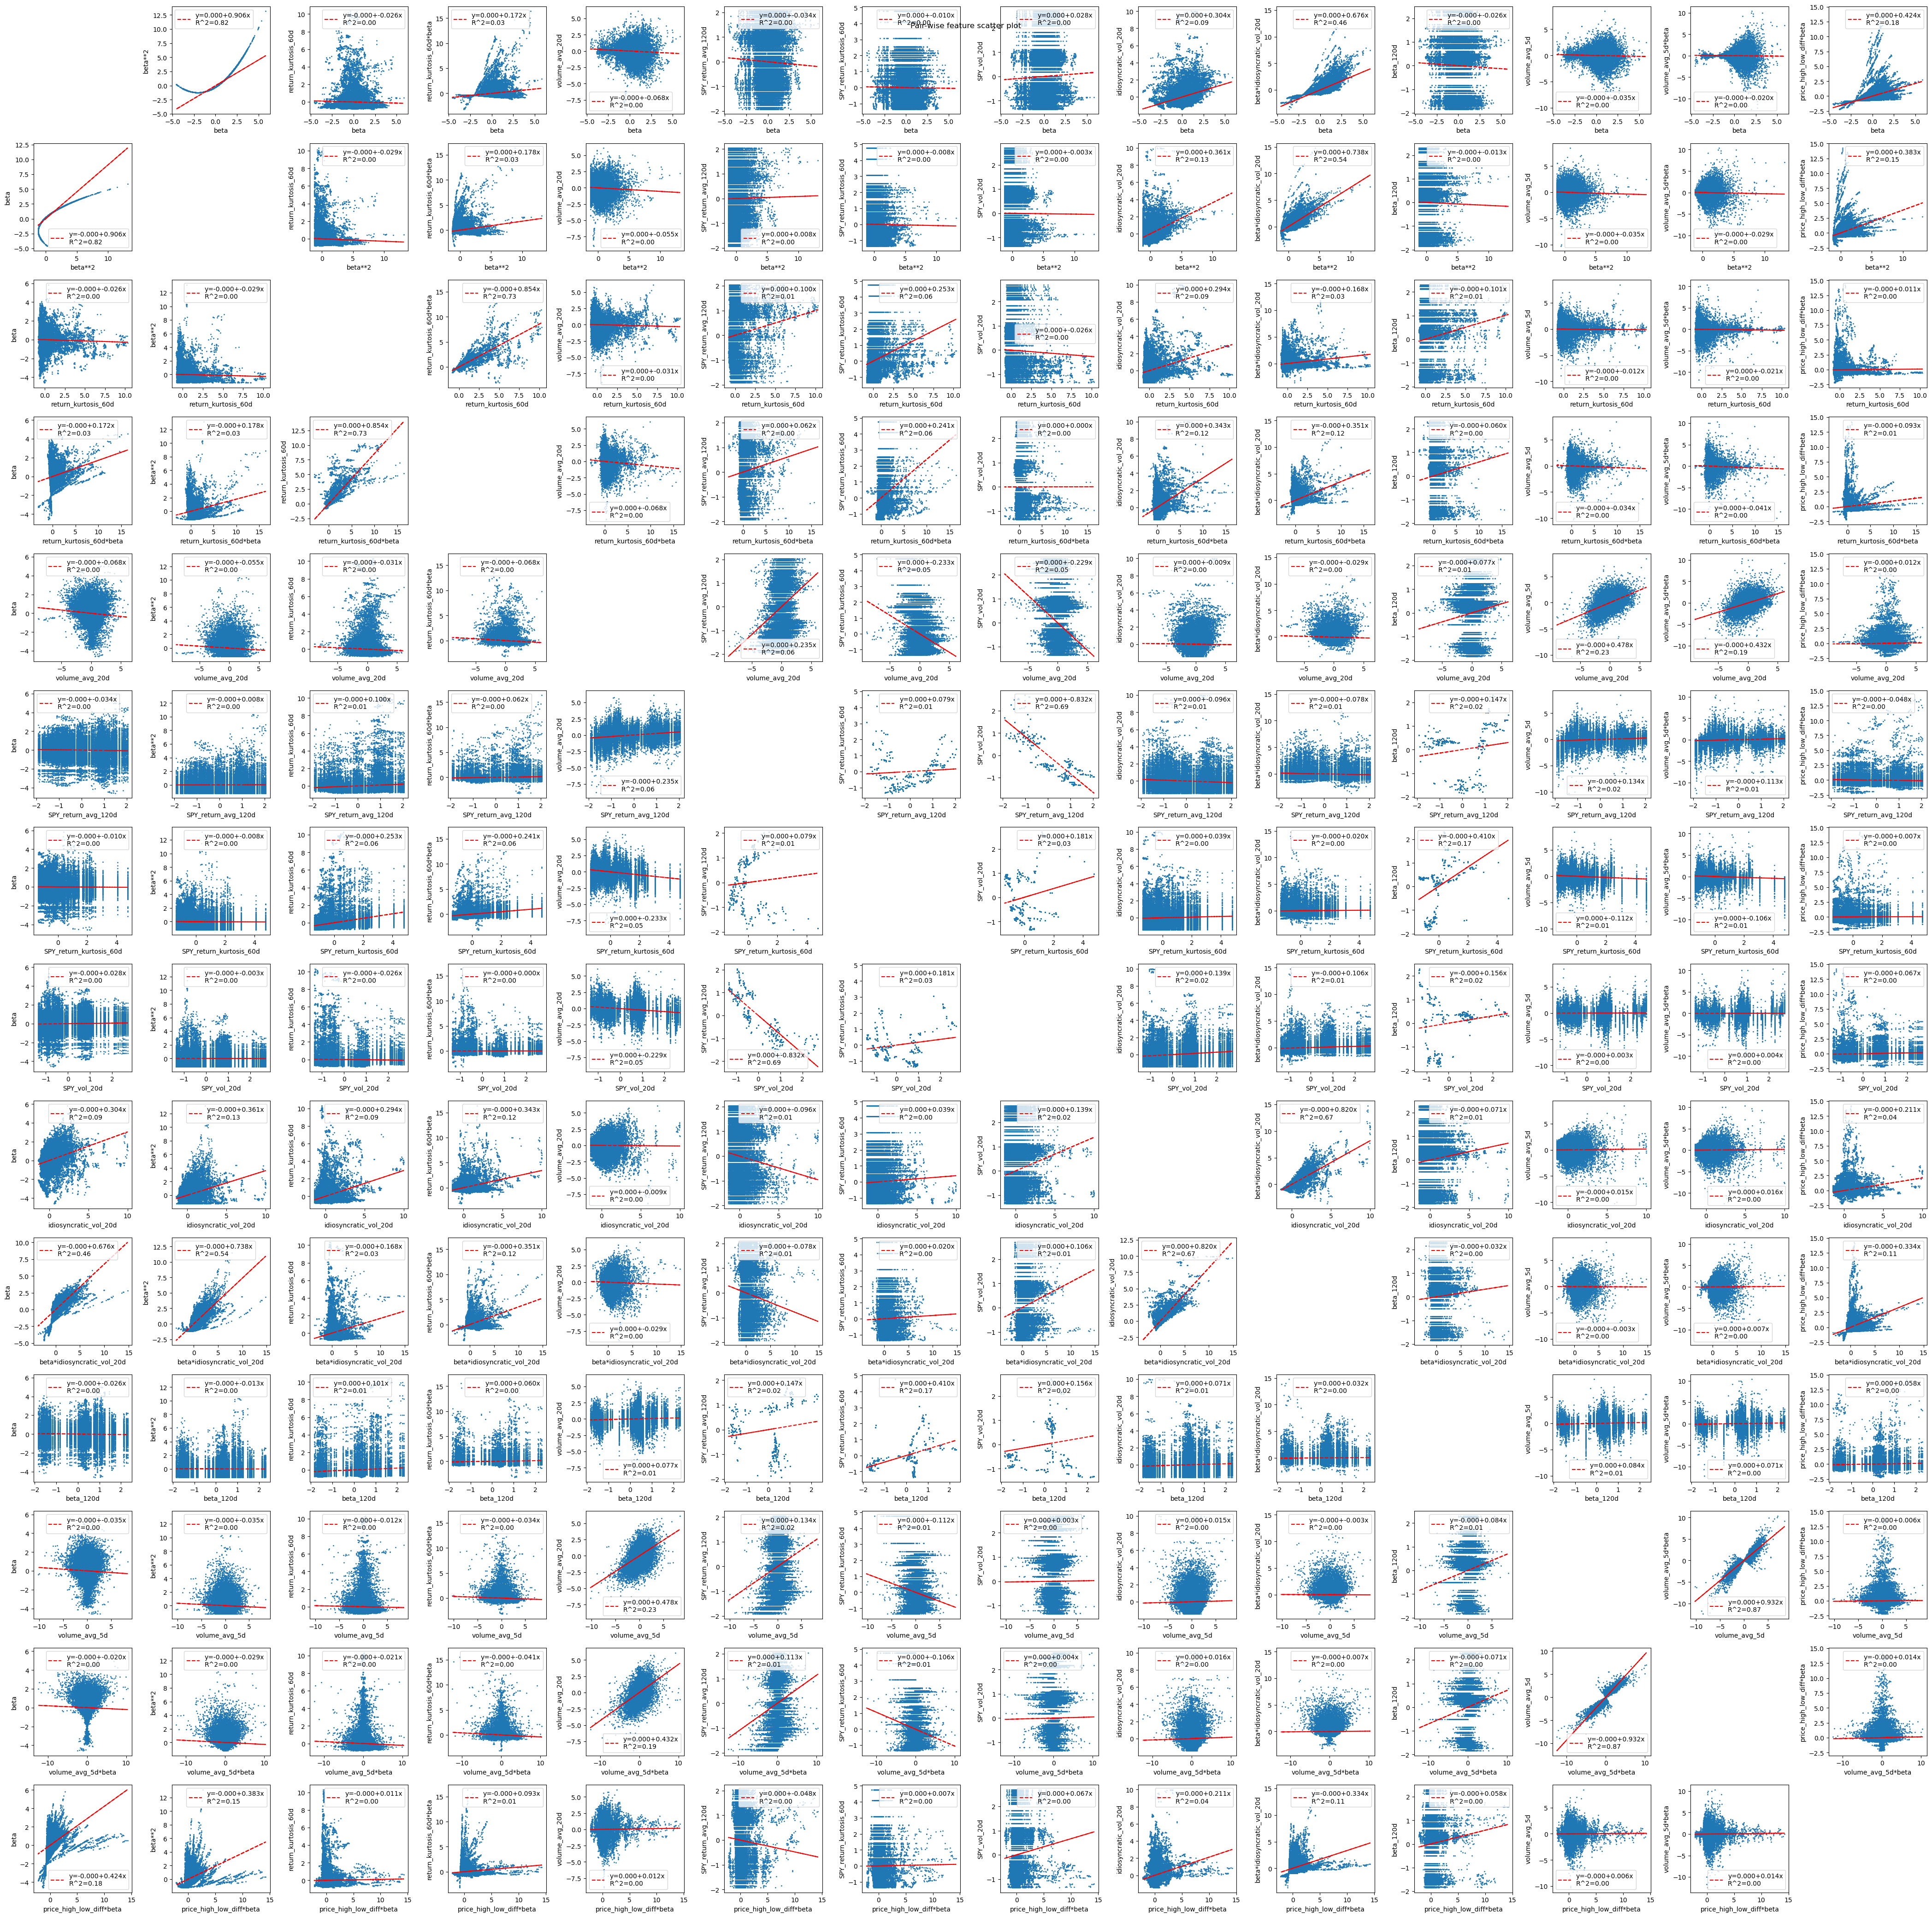

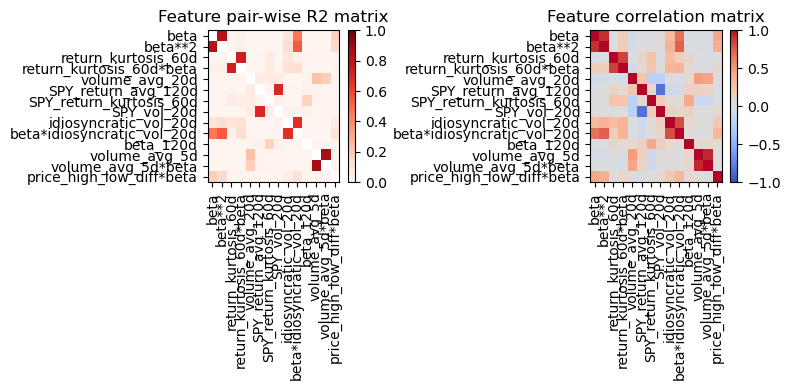

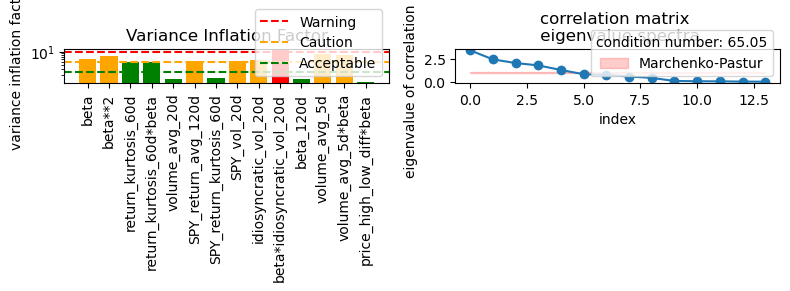

In [2]:
selected_feature = [feature_vote_summary[i][0] for i in range(len(feature_vote_summary)) if feature_vote_summary[i][1] >=3]
#_ = utils.linear_model_diagnosis(selected_feature, year=2012, nonlinearity=True)
_ = utils.linear_model_diagnosis(selected_feature, year=2012, colinearity=True)
selected_feature.remove("beta*idiosyncratic_vol_20d")


### Conclusion:
Analysis above suggests that $\beta*\sigma^{\epsilon}$ is highly correlated with other features. To improve model stability and interpretability, we remove this feature.

As such, we have selected all relevant features. In our following analysis, we consider four groups of features:

(1) **Baseline**: $\beta_{i, t}$, $V_t$, $r_t$

(2) **Small model**: high importance features

(3) **Medium model**: small model + medium importance features

(4) **Large model**: small model + medium importance features + low importance features

## 3. Linear model diagnosis
Before we dive into model optimization, we make some further data analysis with linear regression. Even though the remediation of linear regression is not the focus of our ongoging analysis, we still want to understand the data better and check if there are any potential issues with the data.

Our analysis includes:

### (1) Colinear analysis
Implemented above.

### (2) outlier detection
We use the following metrics to detect outliers:
- Leverage: the diagonal of the hat matrix $H = X(X^TX)^{-1}X^T$, where $X$ is the design matrix. The leverage of an observation is a measure of how much influence it has on the fitted values.
- Internal and external studentized residuals: $r_i = \frac{\varepsilon_i}{\hat{\sigma}\sqrt{1-h_i}}$. Under null hypothesis of linear regression, $r_i \sim t_{N-p-1}$
- Cook's distance: $D_i = \frac{(\hat{\beta} - \hat{\beta}_{-i})^TX^TX(\hat{\beta} - \hat{\beta}_{-i})}{p \hat{\sigma}^2}$. We set the threshold to 4/N.



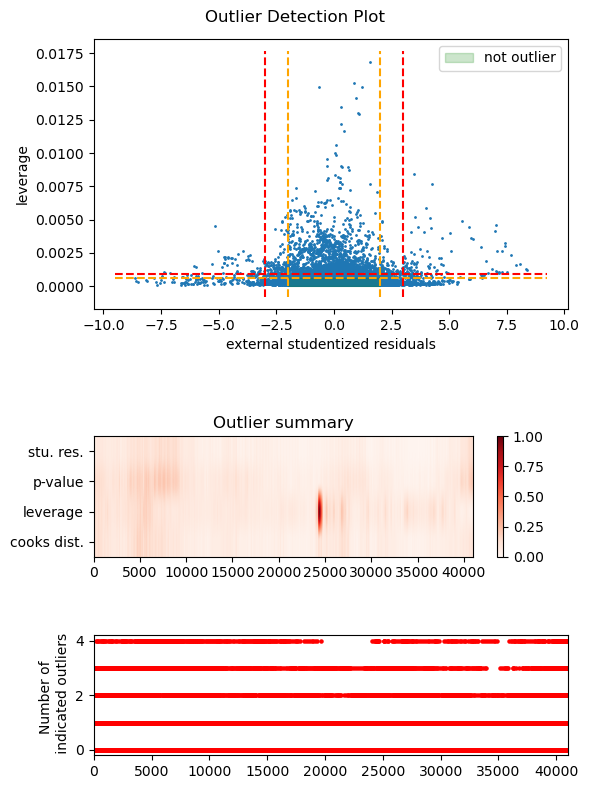

In [3]:
_ = utils.linear_model_diagnosis(selected_feature, year=2012, outlier=True)


### (3) Homoscedasticity
We use the following metrics to detect heteroscedasticity:
- Breusch-Pagan test
    $\hat{\varepsilon}^2 = X\gamma + v$
    H_0: $\gamma = 0$, i.e., homoscedasticity

- Park test
    $\log(\hat{\varepsilon}^2) = \log(X)\gamma + v$
    H_0: $\gamma = 0$, i.e., homoscedasticity

- White test
    $\hat{\varepsilon}^2 = X\gamma + X_iX_j\beta + v$
    H_0: $\gamma = 0$, i.e., homoscedasticity

- Goldfeld-Quandt test (non-parametric)
    H_0: $\sigma^2_{large}/\sigma^2_{small} = 1$, i.e., homoscedasticity
    - Sort the data by the feature suspected to be heteroscedastic
    - Split the data into two groups: large and small
    - Calculate the ratio of the variances of the two groups

- Harrison-McCabe test
    H_0: $\sigma^2_{large}/\sigma^2_{small} = 1$, i.e., homoscedasticity
    - Sort the data by the residuals
    - Split the data into two groups: large and small
    - Calculate the ratio of the variances of the two groups

- Box-Cox transformation
    Find the optimal Box-Cox transformation parameter $\lambda$ that maximizes the log-likelihood function for normal residuals.
    - If $\lambda$ = 1, it suggests no transformation.

- Yeo-Johnson transformation
    Find the optimal Yeo-Johnson transformation parameter $\lambda$ that maximizes the log-likelihood function for normal residuals.
    - If $\lambda$ = 1, it suggests no transformation.



Box-Cox transformation is not applicable because Y exists negative values.


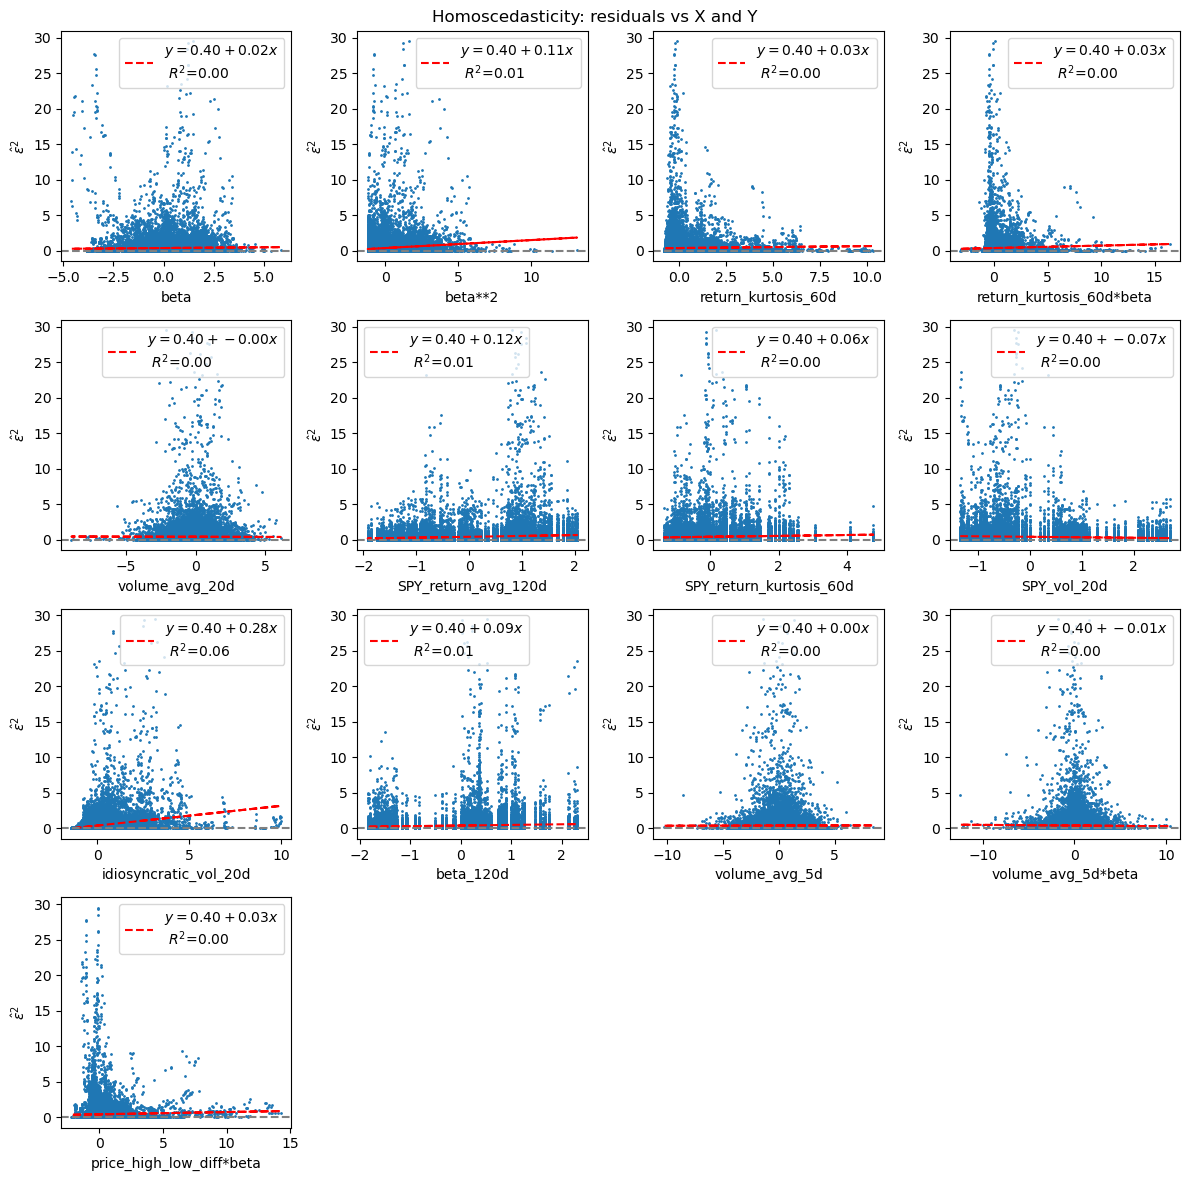

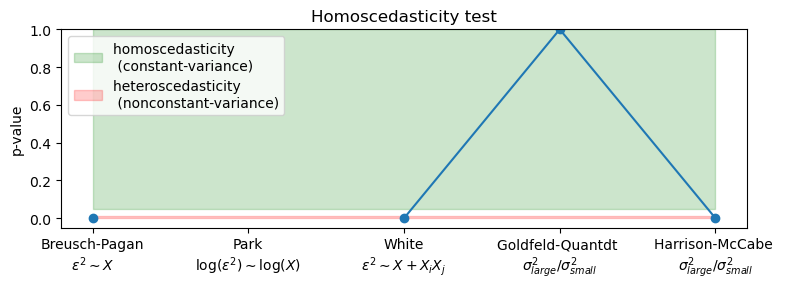

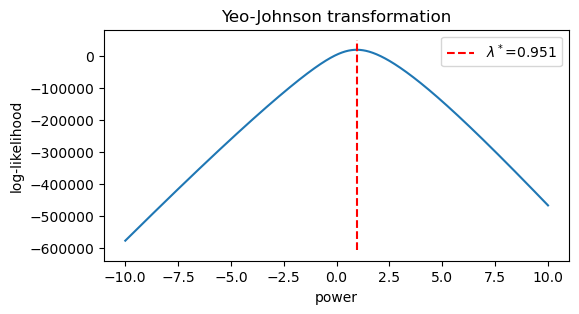

In [4]:
_ = utils.linear_model_diagnosis(selected_feature, year=2012, homoscedasticity=True)


### (4) Normality and independence of $\varepsilon$
We test the normality and independence of the residuals using the following metrics:

- Q-Q plot: plot the quantiles of the residuals against the quantiles of a normal distribution.

- Shapiro-Wilk test (normality test)

- Anderson-Darling test (normality test)

- Jarque-Bera test (normality test)

- Durbin-Watson test (independence test)

    $\varepsilon_i = \rho \varepsilon_{i-1} + v_i, where v_i \sim N(0, \sigma^2)$
    H_0: $\rho = 0$, i.e., independence

- Breusch-Godfrey test (independence test)

    $\varepsilon_i = \rho_1 \varepsilon_{i-1} + \rho_2 \varepsilon_{i-2} + ... + \rho_k \varepsilon_{i-k} + v_i, where v_i \sim N(0, \sigma^2)$
    H_0: $\rho_1 = \rho_2 = ... = \rho_k = 0$, i.e., independence

- Ljung-Box test (independence test)

    H_0: $\rho_1 = \rho_2 = ... = \rho_k = 0$, i.e., independence

- Wald-Wolfowitz test (independence test, run test)

    H_0: $\rho_1 = \rho_2 = ... = \rho_k = 0$, i.e., independence
    - The test statistic is the number of runs in the sequence of residuals.
    - A run is a sequence of consecutive identical signs (positive or negative) in the residuals. 



c:\Users\infiyfl\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


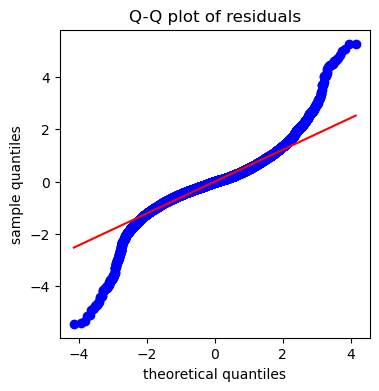

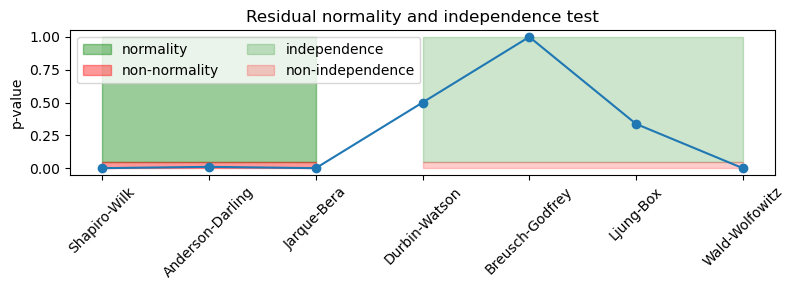

In [5]:
_ = utils.linear_model_diagnosis(selected_feature, year=2012, residual_normality_independence=True)

### (5) Visualize data
We visualize the data by plotting:
- The raw data
- The box plot of each feature
- Project the 14-dimensional feature data into 2D space and color code the points by the forward beta. We use the three method to project the data into 2D space:
    - Principal Component Analysis (PCA)
    - t-Distributed Stochastic Neighbor Embedding (t-SNE)
    - Uniform Manifold Approximation and Projection (UMAP)



summary of the data:
               beta       beta**2  return_kurtosis_60d  \
count  4.103200e+04  4.103200e+04         4.103200e+04   
mean  -2.633807e-14 -1.095545e-14        -1.374607e-15   
std    1.000000e+00  1.000000e+00         1.000000e+00   
min   -4.581310e+00 -1.215518e+00        -8.189246e-01   
25%   -5.643364e-01 -6.902050e-01        -4.871951e-01   
50%    3.586814e-02 -1.948428e-01        -2.908519e-01   
75%    5.558345e-01  3.703067e-01         6.479933e-02   
max    5.834872e+00  1.315144e+01         1.031384e+01   

       return_kurtosis_60d*beta  volume_avg_20d  SPY_return_avg_120d  \
count              4.103200e+04    4.103200e+04         4.103200e+04   
mean              -1.939568e-15    9.448585e-16         1.214479e-14   
std                1.000000e+00    1.000000e+00         1.000000e+00   
min               -3.153857e+00   -8.925849e+00        -1.918790e+00   
25%               -4.342293e-01   -4.833363e-01        -8.751444e-01   
50%               -2.815

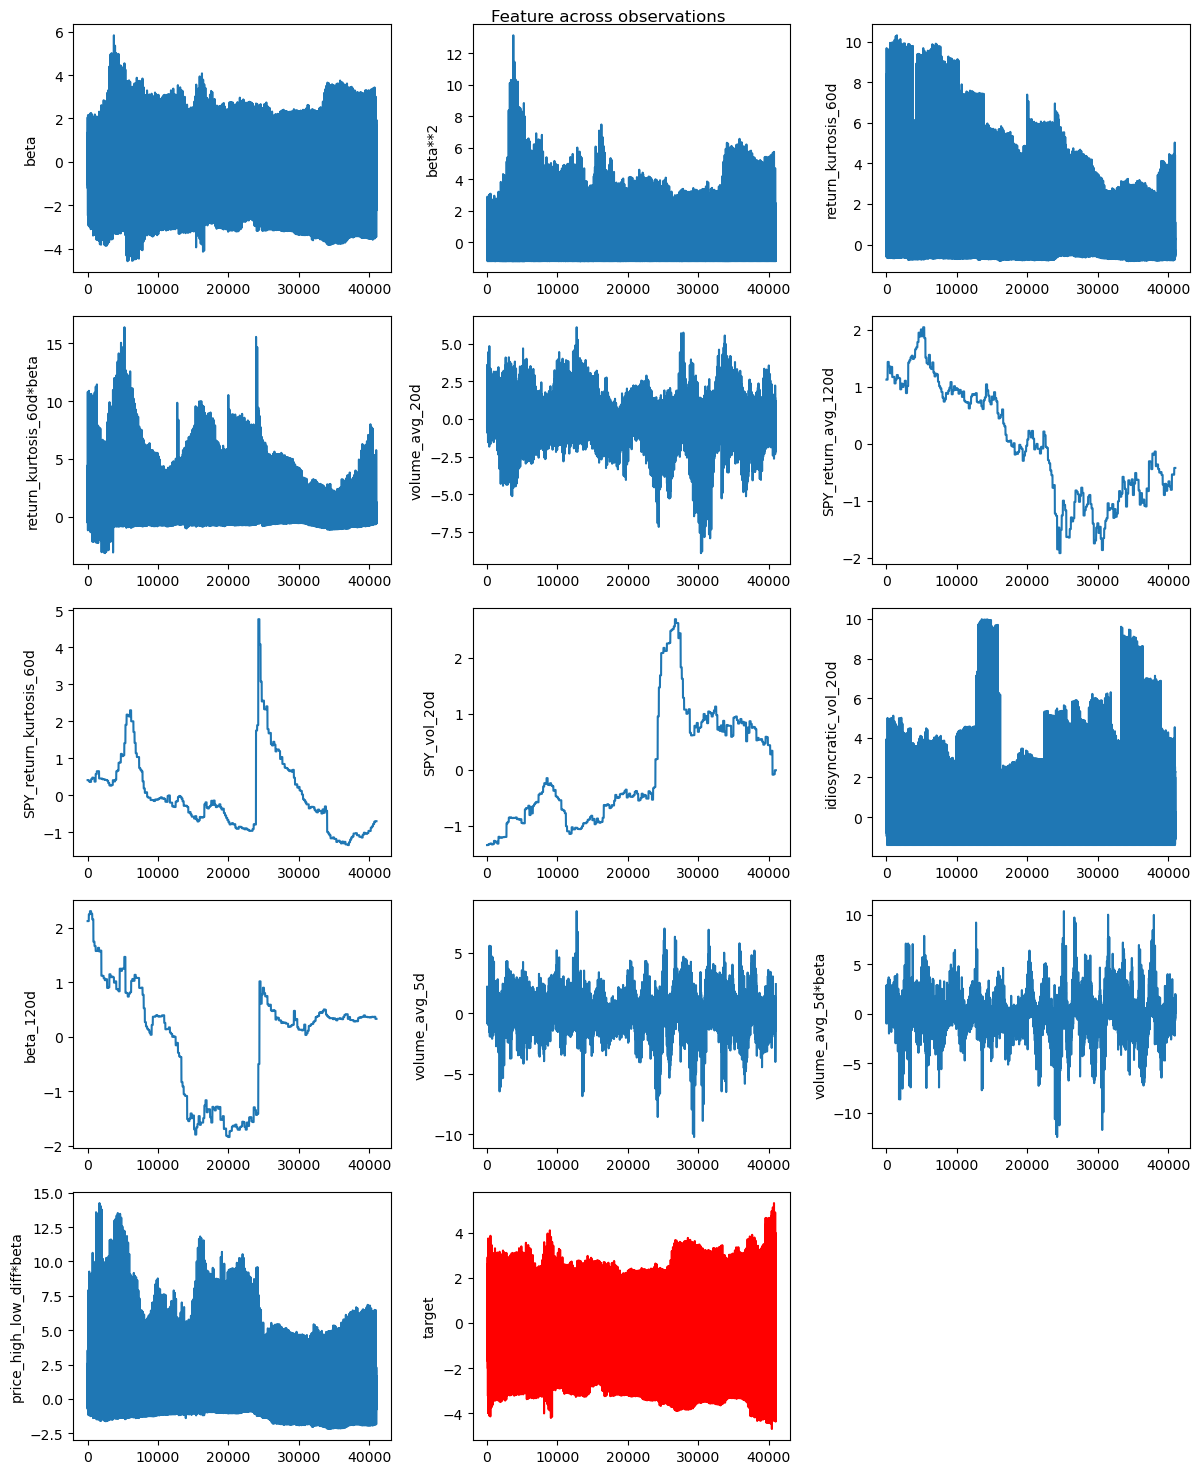

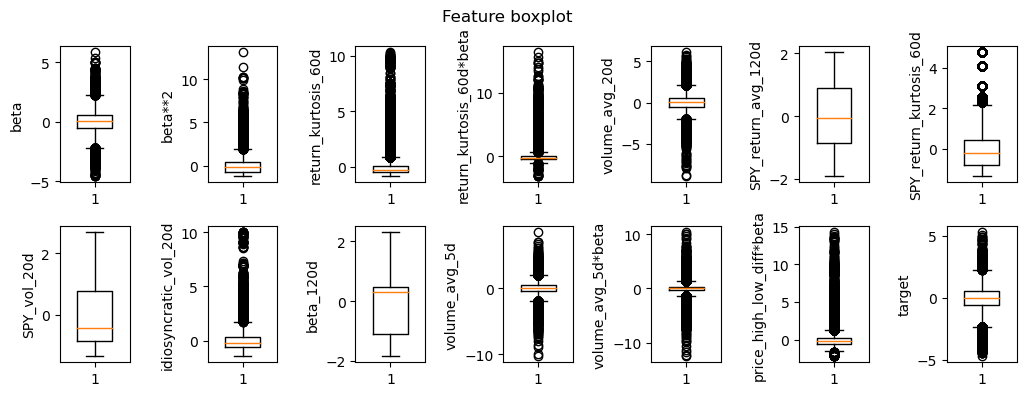

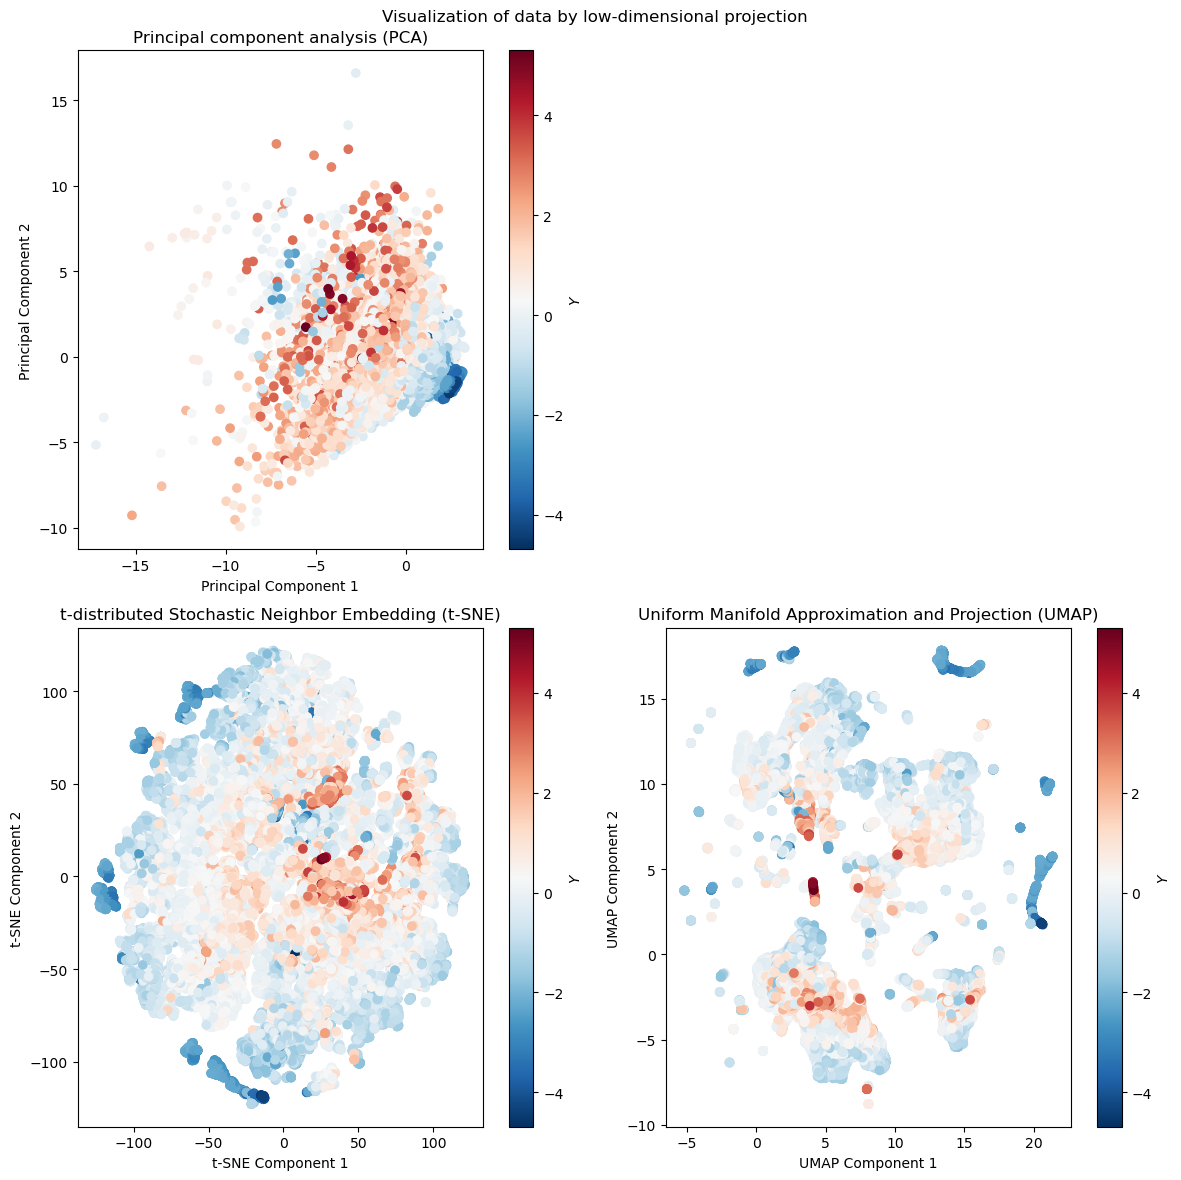

In [6]:
_ = utils.linear_model_diagnosis(selected_feature, year=2012, visualize=True)

In [7]:
selected_feature = [feature_vote_summary[i][0] for i in range(len(feature_vote_summary)) if feature_vote_summary[i][1] >= 3]
file_name = os.path.join(os.getcwd(), "feature_engineer_summary.pkl")
with open(file_name, "wb") as f:
    pickle.dump({"feature_vote": feature_vote_summary, "selected_feature": selected_feature}, f)

print("selected feature:")
print(selected_feature)


selected feature:
['beta', 'beta**2', 'return_kurtosis_60d', 'return_kurtosis_60d*beta', 'volume_avg_20d', 'SPY_return_avg_120d', 'SPY_return_kurtosis_60d', 'SPY_vol_20d', 'idiosyncratic_vol_20d', 'beta*idiosyncratic_vol_20d', 'beta_120d', 'volume_avg_5d', 'volume_avg_5d*beta', 'price_high_low_diff*beta']
